In [1]:
# ==== this should not be necessary - bug?
import sys

sys.path.append('/home/johannes/ldb/ldb_wlexecutor/src/ldb_wlexecutor/analysis/JOBExtended')
# ====

from helper import preprocess_runs

path_name_dict = {
    # 'job': 'imdb_scaled1/benchmark_optimum_runs/job_full_w_optimal.json',
    'JOB-Light': 'imdb_scaled1/benchmark_optimum_runs/job_light_w_optimal_w_idxs.json',
    'JOB': 'imdb_scaled1/benchmark_optimum_runs/job_full_w_optimal_w_idxs.json',
    # 'job_w_idxs_combined': 'imdb_scaled1/join_order_job_w_idxs_combined.json', # we only look at PG plans - hence better optimums are not necessary
    # 'job_extended_w_idxs': 'imdb_scaled1/benchmark_optimum_runs/job_extended_v20250426_w_optimal_w_idxs.json',
    # 'job_extended_w_idxs_combined': 'imdb_scaled1/join_order_JOBExtended_v20250426._combined.json', # we only look at PG plans - hence better optimums are not necessary
    # 'job_extended2_w_idxs': 'imdb_scaled1/benchmark_optimum_runs/job_extended_v20250509_w_optimal_w_idxs.json',
    'JOB-Extended': 'imdb_scaled1/JOBExtended_selection1.json'
}
benchmark_stats_dict = preprocess_runs(path_name_dict)

Loading run files from /mnt/c/PhD/ldb/ldb_data/runs/json
Benchmark: JOB-Light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:01<00:00, 101.06it/s]


Benchmark: JOB (226 plans)


Cleaning SQL: 100%|██████████| 226/226 [00:02<00:00, 101.30it/s]


Benchmark: JOB-Extended (15805 plans)


Cleaning SQL: 100%|██████████| 15805/15805 [00:00<00:00, 74900.23it/s]


# PG Cost Est Analysis

Benchmark       Pearson    Spearman
------------  ---------  ----------
JOB-Light      0.288351    0.894182
JOB            0.219348    0.432089
JOB-Extended   0.40956     0.270613


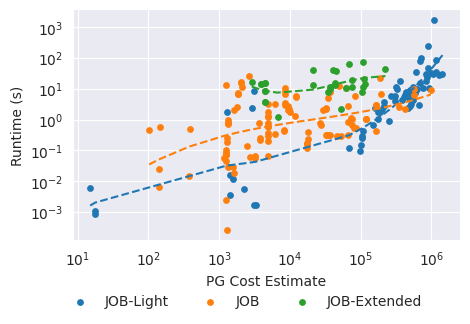

In [18]:
import scipy
from typing import Dict
import matplotlib.pyplot as plt
import numpy as np
import tabulate


def get_pg_cost_est(plan: Dict):
    """
    Get the cost estimate from the plan.
    """
    if 'Plan' in plan:
        return get_pg_cost_est(plan['Plan'])
    if 'Total Cost' in plan:
        return plan['Total Cost']
    return 0


pg_cost_series = dict()

for benchmark_name, info in benchmark_stats_dict.items():
    pg_cost_est_list = []
    for id, (sql, plan_info) in enumerate(info.items()):
        pg_plan = plan_info['pg_plan']
        pg_runtime = plan_info['pg_runtime'] / 1000  # convert to s
        pg_cost_est_list.append((pg_runtime, get_pg_cost_est(pg_plan)))

    pg_cost_series[benchmark_name] = pg_cost_est_list

# create a scatter plot

# create a scatter plot with different benchmarks as different series
plt.figure(figsize=(5, 3))

tabulate_rows = []
for benchmark_name, pg_cost_est_list in pg_cost_series.items():
    runtimes, costs = zip(*pg_cost_est_list)
    plt.scatter(costs, runtimes, label=benchmark_name, s=15)

    # Add a trend line
    z = np.polyfit(np.log(costs), np.log(runtimes), 3)
    p = np.poly1d(z)
    sorted_costs = np.sort(costs)
    plt.plot(sorted_costs, np.exp(p(np.log(sorted_costs))), linestyle='--')

    # compute correlation between cost and runtime
    pearson = scipy.stats.pearsonr(costs, runtimes)[0]
    spearman = scipy.stats.spearmanr(costs, runtimes)[0]
    tabulate_rows.append([benchmark_name, pearson, spearman])

plt.xlabel('PG Cost Estimate')
plt.ylabel('Runtime (s)')
# plt.title('PG Cost Estimate vs Runtime')
plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(-0.05, -0.18), frameon=False)
plt.grid(True)
plt.savefig('/mnt/c/Users/Johannes/Downloads/cost_vs_runtimes.pdf', bbox_inches='tight', dpi=300, transparent=False)

# print table
print(tabulate.tabulate(tabulate_rows, headers=['Benchmark', 'Pearson', 'Spearman']))

